## Checklist
1. frame the problem and look at the big picture
2. get data
3. EDA
4. Prepare Data for ML Algo
5. Model Selection (Linear Regression)
6. Finetuning and Combining models
7. Present Solution
8. Launch monitor and maintain system


In [621]:
# Standard imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.compose import make_column_selector

# models and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# fine tuning
from sklearn.model_selection import GridSearchCV

## 1. frame the problem and look at the big picture

### Defining a Goal
> Predicting a houses median price
- Typical Regression Task

### Selecting a Performance Measure
Root mean square error

### Checking Assumptions
Sense Checking goal and performance measure with the dataset.

## 2. get data

In [622]:
# Importing Data
# https://www.kaggle.com/datasets/camnugent/california-housing-prices

with open('./data/housing.csv') as file:
    df_raw = pd.read_csv(file)

In [623]:
df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [624]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


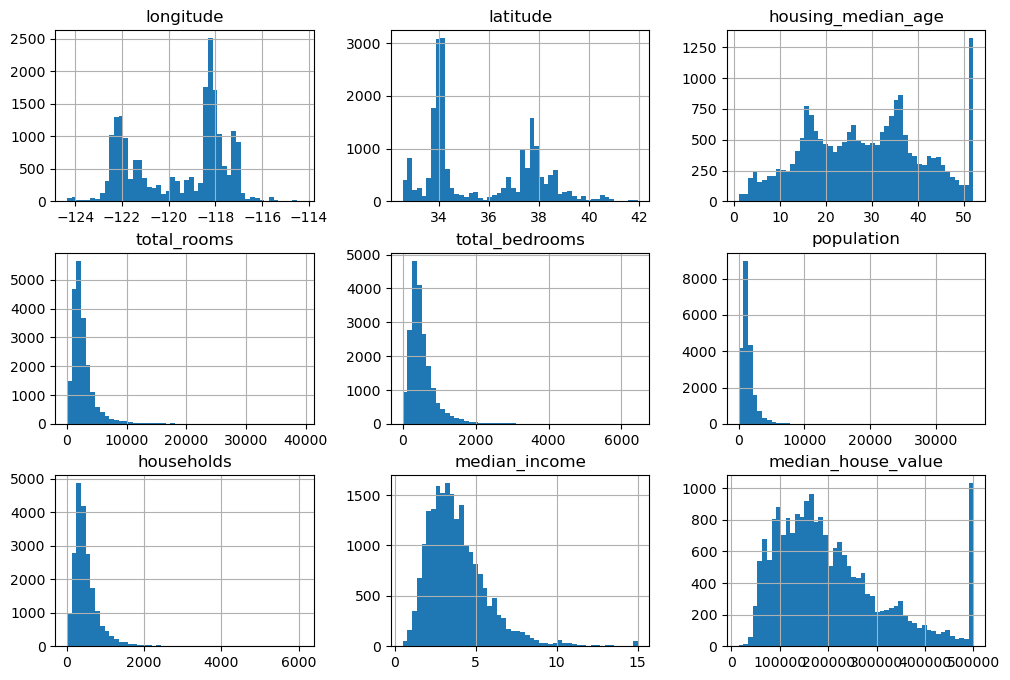

In [625]:
# Distributions
df_raw.hist(bins=50, figsize=(12,8))
plt.show()

In [626]:
# Descriptive Statistics
df_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


1. Having an initial look at the data
- skewness of data
- sides are clipped (all prices over 15000 are bunched together)
2. Then performing some initial data cleaning
- removing clipped values as we want to predict larger values -> (also from testing set as model should not be penalized for such predictions)


In [627]:
# removing clipped values
boolean_mask = df_raw['median_house_value'] < 500000
df_raw = df_raw[boolean_mask]
df_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,19648.000000,19648.000000,19648.000000,19648.000000,19448.000000,19648.000000,19648.000000,19648.000000,19648.000000
mean,-119.562378,35.651872,28.373066,2620.337693,539.645825,1441.368485,501.192488,3.676411,192055.328583
std,2.005760,2.150066,12.504050,2182.371939,422.553057,1144.075196,383.391367,1.570602,97110.854998
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.760000,33.930000,18.000000,1438.000000,297.000000,796.000000,282.000000,2.526300,116475.000000
50%,-118.500000,34.270000,28.000000,2111.000000,436.000000,1179.000000,411.000000,3.449050,173600.000000
75%,-117.990000,37.730000,37.000000,3121.000000,648.000000,1746.250000,606.000000,4.582500,247900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,499100.000000


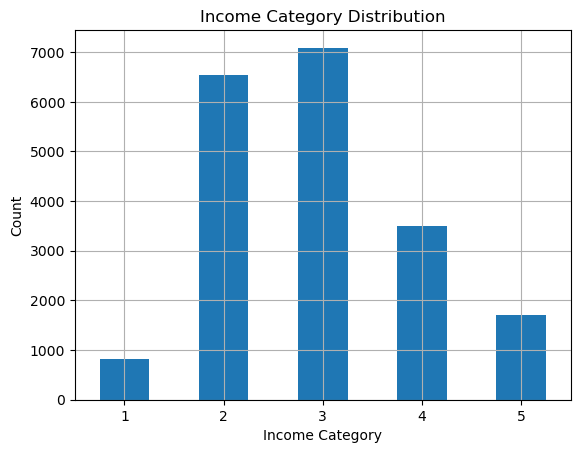

In [628]:
# train test split (80/20)(stratified)
# stratified to avoid sampling bias due to small dataset

df_raw['income_cat'] = pd.cut(df_raw['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Plotting histogram of income category distribution
df_raw['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.title('Income Category Distribution')
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.show()


strat_train_set, strat_test_set = train_test_split(df_raw, test_size=0.2, random_state=7, stratify=df_raw['income_cat']) #stratifies by bins created in income_cat

# Dropping income_cat column from train and test sets
for _set in (strat_train_set, strat_test_set):
    _set.drop('income_cat', axis=1, inplace=True)


## 3. EDA

In [629]:
# DataFrames for EDA
df_train = strat_train_set.copy()
df_train_num = df_train.select_dtypes(include=[np.number])
df_train_cat = df_train[['ocean_proximity']]

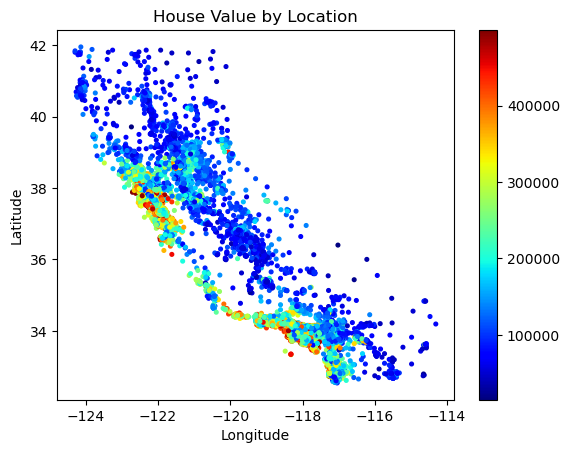

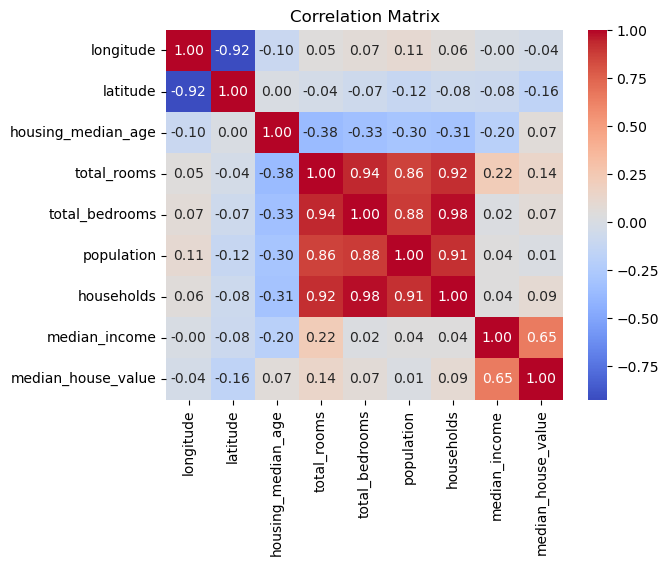

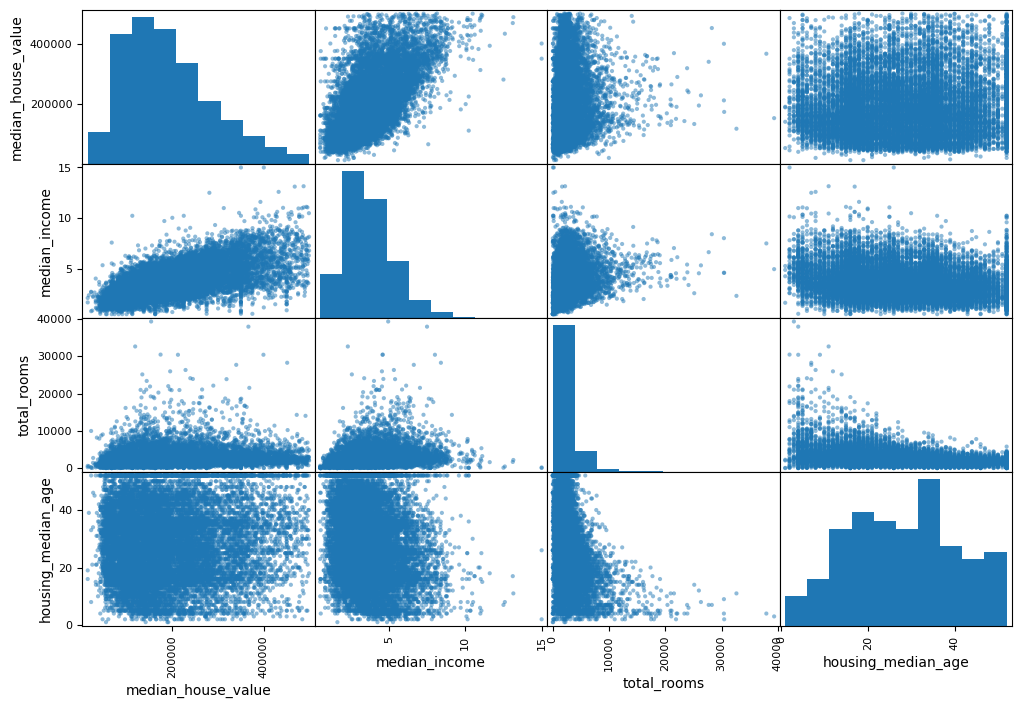

In [630]:
# 1. Visualiztation

# lon vs lat coloring by house value
plt.scatter(data=df_train, x='longitude', y='latitude', alpha=1, s=7,c='median_house_value', cmap='jet')
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('House Value by Location')
plt.show()

# 2. Correlations
corr_matrix = df_train_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(df_train[attributes], figsize=(12,8))
plt.show()

In [631]:
# 2. combining features

df_train['*rooms_per_house'] = df_train['total_rooms'] / df_train['households']
df_train['*bedrooms_vs_total_Rooms'] = df_train['total_bedrooms'] / df_train['total_rooms']
df_train['*people_per_house'] = df_train['population'] / df_train['households']

# calculating new correlations
corr_matrix = df_train_num.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.647245
total_rooms           0.142045
households            0.091370
total_bedrooms        0.071477
housing_median_age    0.067687
population            0.011480
longitude            -0.036807
latitude             -0.157913
Name: median_house_value, dtype: float64

## 4. Prepare Data for ML Algo

In [632]:
# custom functions
def log1p_transform(data):
    """
    better than standard log transformation => handles zero values.
    ---
    params:
        data: pd.Series
    return: 
        log_data: pd.Series
    """
    if data.min() < 0:
        raise ValueError("Data contains non-positive values, cannot apply log transformationraise")
    else:
        log_data = np.log1p(data)
    return log_data


def ratio(data):
    return data[:,[0]] / data[:,[1]]

def ratio_name(funciton_transformer, input_features):
    return ['ratio']

In [633]:
# custom classes

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=0.1, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f'Cluster {i} similarity' for i in range(self.n_clusters)]

In [634]:
# transformers

ohe = OneHotEncoder()
imp = SimpleImputer(strategy='median')
scl = StandardScaler()

# custom transformer functions
l1p = FunctionTransformer(func=log1p_transform, feature_names_out='one-to-one', validate=False)
div = FunctionTransformer(func=ratio, feature_names_out=ratio_name, validate=False)
sim = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=7)



In [635]:
# Building Pipelines

ppl_log = Pipeline([
    ('impute',imp) ,
    ('log1p', l1p),
    ('scale', scl)  
])

ppl_ratio = Pipeline([
    ('impute', imp),
    ('ratio', div),
    ('scale', scl)
])

ppl_num = Pipeline([
    ('impute', imp),
    ('scale', scl)
])

ppl_cat = Pipeline([
    ('onehot', ohe)
])

ppl_geo = Pipeline([
    ('simmilarities', sim)
])

In [636]:
# Combining Pipelines in Column Transformer


preprocessing = ColumnTransformer([
    ('ratio_bedrooms', ppl_ratio, ['total_bedrooms', 'total_rooms']),
    ('ratio_rooms_per_house', ppl_ratio, ['total_rooms', 'households']),
    ('ratio_people_per_house', ppl_ratio, ['population', 'total_bedrooms']),
    ('log1p', ppl_log, ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']),
    ('geo_similarities', ppl_geo, ['latitude', 'longitude']),
    ('categorical_data', ppl_cat, make_column_selector(dtype_include=['object'])),
], remainder=ppl_num)

## 5. Model Selection

In [637]:
# defining X and y
X = strat_train_set.copy().drop('median_house_value', axis=1)
y = strat_train_set['median_house_value']


In [638]:
# linear regression

ppl_lin_reg = make_pipeline(preprocessing, LinearRegression())
mod_lin_reg = ppl_lin_reg.fit(X, y)
prd_lin_reg = mod_lin_reg.predict(X)

# plotting predictions
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['prediction', 'actual', 'difference']
for i in range(10):
    table.add_row([prd_lin_reg[i], y.iloc[i], prd_lin_reg[i] - y.iloc[i]])
print(table)

# evaluation
rmse_lin_reg = root_mean_squared_error(y, prd_lin_reg)
print(f'root mean square error: {rmse_lin_reg}')


+------------+----------+------------+
| prediction |  actual  | difference |
+------------+----------+------------+
|  138272.0  | 127200.0 |  11072.0   |
|  171744.0  | 300000.0 | -128256.0  |
|  195456.0  | 104200.0 |  91256.0   |
|  149888.0  | 125900.0 |  23988.0   |
|  107520.0  | 270000.0 | -162480.0  |
|  234304.0  | 197400.0 |  36904.0   |
|  124128.0  | 212500.0 |  -88372.0  |
|  146144.0  | 131300.0 |  14844.0   |
|  222464.0  | 196800.0 |  25664.0   |
|  135008.0  | 106000.0 |  29008.0   |
+------------+----------+------------+
root mean square error: 57929.05413915198


In [639]:
# decision tree
ppl_dec_tree = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=7))
ppl_dec_tree.fit(X, y)
prd_dec_tree = ppl_dec_tree.predict(X)

# evaluation
rsme_dec_tree = root_mean_squared_error(y, prd_dec_tree)
print(rsme_dec_tree) # rsme of 0 => overfit model

# k-folds cross validation
tree_rsmes = -cross_val_score(ppl_dec_tree, X, y, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(tree_rsmes).describe() # results not great compared to linear regression

0.0


count       10.000000
mean     60851.024237
std       1269.842391
min      58999.567536
25%      59810.831200
50%      60701.064098
75%      61930.783870
max      62725.975501
dtype: float64

In [640]:
# random forrest
ppl_forrest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=7))
rmses_forrest = -cross_val_score(ppl_forrest_reg, X, y, scoring='neg_root_mean_squared_error', cv=10)
pd.Series(rmses_forrest).describe()

count       10.000000
mean     42837.686660
std       1544.122382
min      41370.328366
25%      41545.520890
50%      42559.639594
75%      43413.180300
max      46012.520015
dtype: float64

## 6. Finetuning and Combining models

In [641]:
# grd search
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=7))
    ])
param_grid = [
    {'preprocessing__geo_similarities__simmilarities__n_clusters': [5,8,10], 'random_forest__max_features':[4,6,8]},
    {'preprocessing__geo_similarities__simmilarities__n_clusters': [10,15], 'random_forest__max_features':[6,8,10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

# alternative: randomized search (can be more accurate but more iterations)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scale',
                                                                                     StandardScaler())]),
                                                          transformers=[('ratio_bedrooms',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratio',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_name at 0x316637d80>...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x314260110>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=7))]),
             param_grid=[{'preprocessing__geo_similarities__simmilarities__n_clusters': [5,
                                                                                         8,
                                                                                         10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo_similarities__simmilarities__n_clusters': [10,
                                                                                         15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [642]:
# results
print(grid_search.best_params_)
pd.DataFrame(grid_search.cv_results_)

{'preprocessing__geo_similarities__simmilarities__n_clusters': 15, 'random_forest__max_features': 6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo_similarities__simmilarities__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.268371,0.109645,0.101533,0.013778,5,4,{'preprocessing__geo_similarities__simmilariti...,-41383.730704,-44174.558894,-43674.613490,-43077.634363,1215.035954,14
1,3.121776,0.039892,0.102877,0.005929,5,6,{'preprocessing__geo_similarities__simmilariti...,-41356.630800,-43880.161831,-43650.704258,-42962.498963,1139.377641,13
2,3.929529,0.052567,0.088562,0.004013,5,8,{'preprocessing__geo_similarities__simmilariti...,-41696.043698,-44267.549418,-44285.274490,-43416.289202,1216.418785,15
3,2.290832,0.033533,0.095943,0.008764,8,4,{'preprocessing__geo_similarities__simmilariti...,-39760.792476,-42568.368362,-41954.225534,-41427.795457,1205.118821,7
4,3.181006,0.043563,0.093840,0.006687,8,6,{'preprocessing__geo_similarities__simmilariti...,-40019.780046,-42740.489159,-42288.466086,-41682.911764,1190.402326,10
5,4.144097,0.094510,0.129299,0.056538,8,8,{'preprocessing__geo_similarities__simmilariti...,-40257.485698,-43005.828687,-42911.650678,-42058.321688,1273.963650,12
6,2.391614,0.142409,0.092112,0.012115,10,4,{'preprocessing__geo_similarities__simmilariti...,-39080.859550,-41774.172840,-41548.886648,-40801.306346,1220.011298,3
7,3.416062,0.104923,0.100214,0.009984,10,6,{'preprocessing__geo_similarities__simmilariti...,-39651.952231,-41937.971054,-42022.193400,-41204.038895,1098.029481,5
8,4.352898,0.038094,0.108815,0.004738,10,8,{'preprocessing__geo_similarities__simmilariti...,-39924.454780,-42207.298162,-42304.214981,-41478.655974,1099.698211,8
9,3.279344,0.109354,0.093514,0.013302,10,6,{'preprocessing__geo_similarities__simmilariti...,-39651.952231,-41937.971054,-42022.193400,-41204.038895,1098.029481,5


In [643]:
# final model
final_model = grid_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_.round(2)
pd.DataFrame(sorted(zip(feature_importances, final_model['preprocessing'].get_feature_names_out()), reverse=True), columns=['importance','feature_name'])

,importance,feature_name
0,0.21,log1p__median_income
1,0.12,categorical_data__ocean_proximity_INLAND
2,0.07,ratio_bedrooms__ratio
3,0.05,ratio_rooms_per_house__ratio
4,0.05,ratio_people_per_house__ratio
5,0.05,geo_similarities__Cluster 2 similarity
6,0.04,geo_similarities__Cluster 8 similarity
7,0.04,geo_similarities__Cluster 5 similarity
8,0.04,geo_similarities__Cluster 1 similarity
9,0.03,geo_similarities__Cluster 4 similarity


In [644]:
# testing variables
X_test = strat_test_set.copy().drop('median_house_value',axis=1)
y_test = strat_test_set['median_house_value']

In [645]:
# analyzing best models
final_predictions = final_model.predict(X_test)


final rmse: 38233.8510227727
+------------+----------+------------+
| prediction |  actual  | difference |
+------------+----------+------------+
|  173775.0  | 150800.0 |  22975.0   |
|  209886.0  | 161200.0 |  48686.0   |
|  172313.0  | 155800.0 |  16513.0   |
|  88983.0   | 175000.0 |  -86017.0  |
|  280867.0  | 225000.0 |  55867.0   |
|  120212.0  | 116700.0 |   3512.0   |
|  87112.0   | 116700.0 |  -29588.0  |
|  254206.0  | 289600.0 |  -35394.0  |
|  215015.0  | 196400.0 |  18615.0   |
|  199899.0  | 209200.0 |  -9301.0   |
+------------+----------+------------+


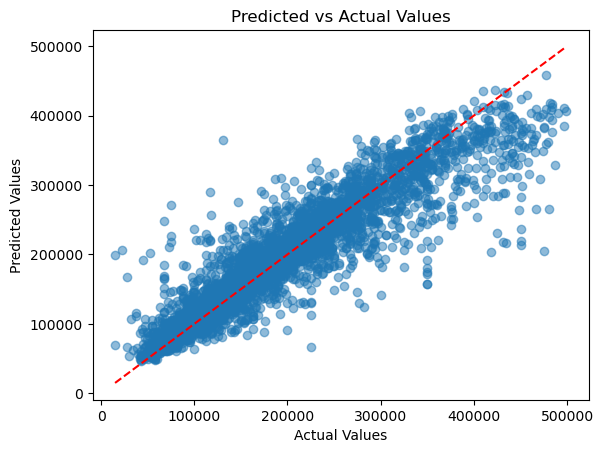

In [647]:
# evaluate on test set
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(f'final rmse: {final_rmse}')
# plotting predictions
table = PrettyTable()
table.field_names = ['prediction', 'actual', 'difference']
for i in range(10):
    table.add_row([final_predictions[i], y_test.iloc[i], final_predictions[i] - y_test.iloc[i]])
print(table)
# plotting predictions
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


## 7. Present Solution

## 8. Launch monitor and maintain system